# ROC analysis for Sophon model
This notebook computes multiclass ROC curves (one-vs-rest) and micro/macro AUC for the Sophon model using the CSV with model probabilities.

Workflow:
- Load a stratified sample of the CSV (to keep memory usage reasonable)
- Compute per-class and micro/macro ROC
- Plot and save the figure to `roc_sophon.png`

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Plot settings
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100

# Path to CSV (adjust if you used a different filename)
CSV_PATH = 'inference_5M_percentage_with_probs.csv'
# If CSV is very large, set SAMPLE_FRAC to a small float (e.g., 0.1) or set SAMPLE_N to an int
SAMPLE_FRAC = 1.0
SAMPLE_N = None  # set to None to disable row-count sampling

# Helper: read a manageable sample preserving class balance
def load_sample(csv_path, sample_frac=None, sample_n=None, random_state=42):
    # quick header check
    df_head = pd.read_csv(csv_path, nrows=2)
    prob_cols = [c for c in df_head.columns if c.startswith('prob_')]
    if len(prob_cols) == 0:
        raise RuntimeError('No prob_* columns found in CSV; ensure you ran inference with probabilities enabled')
    # If small file or no sampling requested, read full
    if sample_frac is None and sample_n is None:
        return pd.read_csv(csv_path)

    # else sample by reading in chunks and performing stratified sampling
    reader = pd.read_csv(csv_path, chunksize=100000)
    parts = []
    for chunk in reader:
        if sample_frac is not None:
            parts.append(chunk.sample(frac=sample_frac, random_state=random_state))
        elif sample_n is not None:
            # sample proportionally from chunk
            frac = min(1.0, sample_n / max(1, len(chunk)))
            parts.append(chunk.sample(frac=frac, random_state=random_state))
    df = pd.concat(parts, ignore_index=True)
    # if sample_n specified, downsample to exact n with stratify-like approach
    if sample_n is not None and len(df) > sample_n:
        df = df.sample(n=sample_n, random_state=random_state)
    return df

print('Notebook cells ready. Adjust SAMPLE_FRAC or SAMPLE_N and run the next cell to load data.')

Notebook cells ready. Adjust SAMPLE_FRAC or SAMPLE_N and run the next cell to load data.


In [2]:
# Load a sample (or full file if SAMPLE_FRAC and SAMPLE_N are None)
df = load_sample(CSV_PATH, sample_frac=SAMPLE_FRAC, sample_n=SAMPLE_N)
print(f"Loaded {len(df):,} rows from {CSV_PATH}")

# identify prob columns
prob_cols = [c for c in df.columns if c.startswith('prob_')]
print('Detected probability columns:', prob_cols[:8], '... total', len(prob_cols))

# prepare arrays for ROC
X_probs = df[prob_cols].values
y_true = df['truth_label'].values
classes = np.unique(y_true)
print('Classes found:', classes)

# Binarize labels
Y = label_binarize(y_true, classes=classes)
if Y.shape[1] != len(prob_cols):
    print('Warning: number of prob columns (', len(prob_cols), ') differs from number of classes (', len(classes), ')')

# compute per-class ROC curves and AUC
n_classes = Y.shape[1]
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], X_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr['micro'], tpr['micro'], _ = roc_curve(Y.ravel(), X_probs.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

print('Computed ROC curves and AUCs')
for i in range(n_classes):
    print(f'Class {classes[i]} AUC = {roc_auc[i]:.4f}')
print(f"Micro AUC = {roc_auc['micro']:.4f}, Macro AUC = {roc_auc['macro']:.4f}")

Loaded 11,000 rows from inference_5M_percentage_with_probs.csv
Detected probability columns: ['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5', 'prob_6', 'prob_7'] ... total 10
Classes found: [0 1 2 3 4 5 6 7 8 9]
Computed ROC curves and AUCs
Class 0 AUC = 0.9990
Class 1 AUC = 0.4628
Class 2 AUC = 0.5868
Class 3 AUC = 0.5421
Class 4 AUC = 0.4383
Class 5 AUC = 0.7334
Class 6 AUC = 0.3956
Class 7 AUC = 0.6394
Class 8 AUC = 0.4975
Class 9 AUC = 0.5921
Micro AUC = 0.5481, Macro AUC = 0.5888


C:\Users\N0EL\AppData\Local\Temp\ipykernel_23888\841360586.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


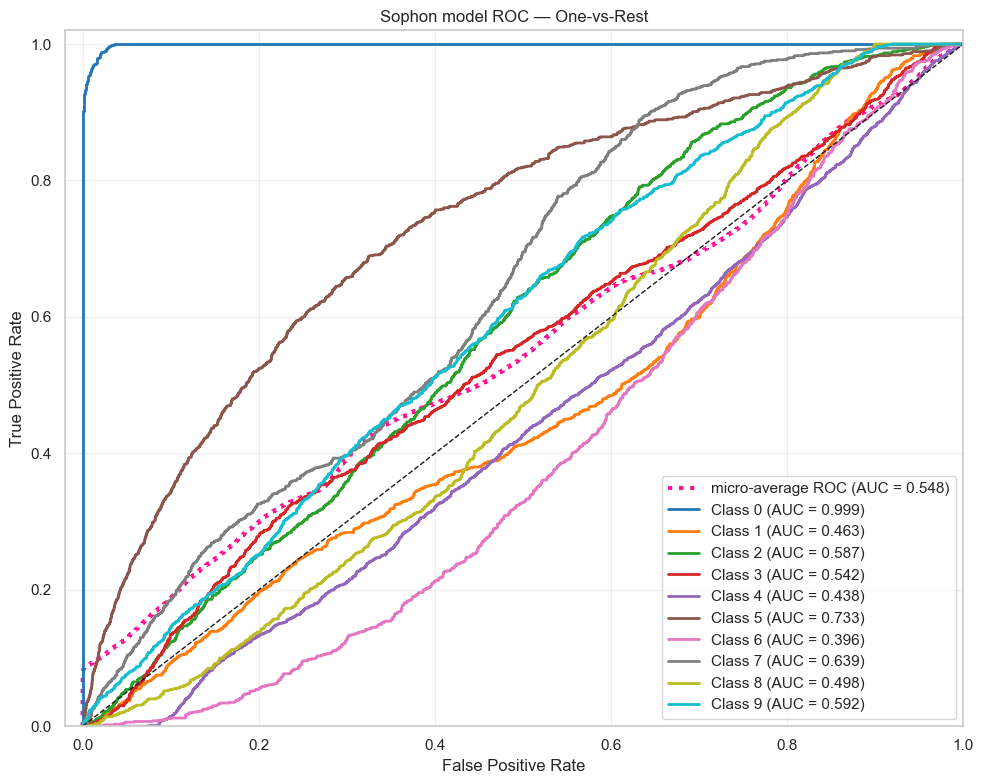

Saved ROC plot to roc_sophon.png


In [3]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr['micro'], tpr['micro'],
         label=f'micro-average ROC (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)

colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i % 10), lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sophon model ROC — One-vs-Rest')
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_sophon.png', dpi=150)
plt.show()

print('Saved ROC plot to roc_sophon.png')

Iteration 1, loss = 1.46468055
Validation score: 0.556818
Iteration 2, loss = 1.06265901
Validation score: 0.602273
Iteration 2, loss = 1.06265901
Validation score: 0.602273
Iteration 3, loss = 0.94885417
Validation score: 0.622727
Iteration 3, loss = 0.94885417
Validation score: 0.622727
Iteration 4, loss = 0.87607946
Validation score: 0.657955
Iteration 4, loss = 0.87607946
Validation score: 0.657955
Iteration 5, loss = 0.83832744
Validation score: 0.671591
Iteration 5, loss = 0.83832744
Validation score: 0.671591
Iteration 6, loss = 0.77752191
Validation score: 0.652273
Iteration 6, loss = 0.77752191
Validation score: 0.652273
Iteration 7, loss = 0.72741414
Validation score: 0.693182
Iteration 7, loss = 0.72741414
Validation score: 0.693182
Iteration 8, loss = 0.69547274
Validation score: 0.725000
Iteration 8, loss = 0.69547274
Validation score: 0.725000
Iteration 9, loss = 0.66999475
Validation score: 0.706818
Iteration 9, loss = 0.66999475
Validation score: 0.706818
Iteration 10, 

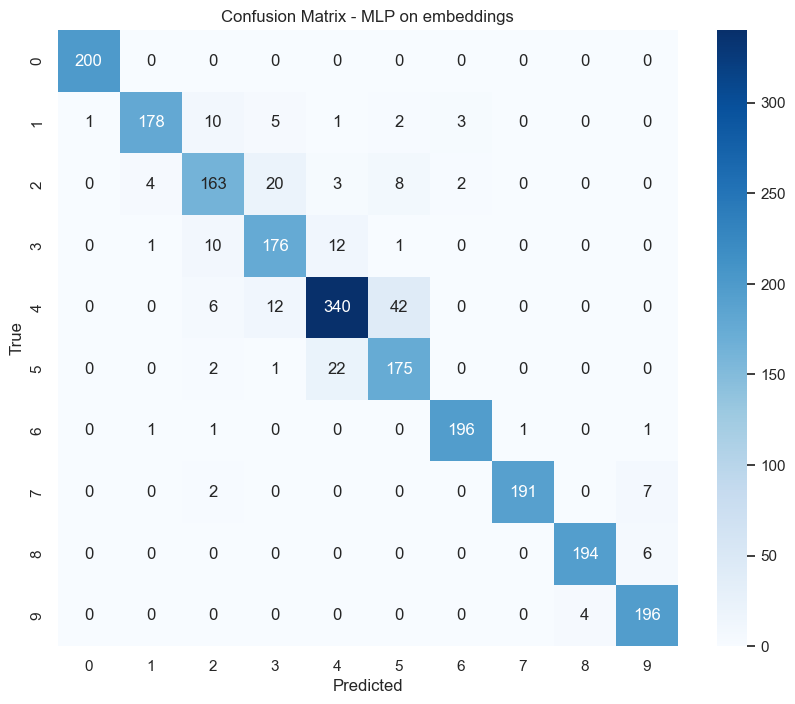

Saved model to mlp_embeddings.joblib and scaler to mlp_scaler.joblib


In [4]:
# Train an MLP on embeddings (fast baseline)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# CONFIG
CSV_PATH = "inference_5M_percentage_with_probs.csv"  # change if using another file
SAMPLE_N = 20000   # set to None to use full dataset; smaller for quick iteration
RANDOM_STATE = 42

# 1) Load data (sample if requested)
df = pd.read_csv(CSV_PATH, nrows=SAMPLE_N) if SAMPLE_N is not None else pd.read_csv(CSV_PATH)
emb_cols = [c for c in df.columns if c.startswith("emb_")]
X = df[emb_cols].values
y = df["truth_label"].values

# 2) Train/test split (stratified to preserve class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 3) Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 4) Baseline MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),   # start reasonably large
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=RANDOM_STATE,
    verbose=True
)
mlp.fit(X_train_s, y_train)

# 5) Evaluate
y_pred = mlp.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP on embeddings")
plt.show()

# 6) Save model and scaler
joblib.dump(mlp, "mlp_embeddings.joblib")
joblib.dump(scaler, "mlp_scaler.joblib")
print("Saved model to mlp_embeddings.joblib and scaler to mlp_scaler.joblib")